In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

N_THREADS = "4"
os.environ["OMP_NUM_THREADS"] = N_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = N_THREADS
os.environ["MKL_NUM_THREADS"] = N_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = N_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = N_THREADS

import gEconpy as ge
import numpy as np
import pandas as pd
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import arviz as az
from corner import corner

from pymc.model.transform.optimization import freeze_dims_and_data
import nutpie as ntp

In [3]:
gcn_file = "../GCN Files/sims_2024/nk_with_sticky_wages.gcn"
mod = ge.model_from_gcn(gcn_file)

Model Building Complete.
Found:
	19 equations
	19 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t, nu_p_t
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	15 parameters
		 13 / 15 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



In [4]:
ge.check_steady_state(mod)

Steady state successfully found!


In [5]:
ge.check_bk_condition(mod);

Model solution has 7 eigenvalues greater than one in modulus and 7 forward-looking variables. 
Blanchard-Kahn condition is satisfied.


In [6]:
irf_scenarios = {
    "both_sticky": {"phi_p": 0.75, "phi_w": 0.75},
    "prices_sticky": {"phi_p": 0.75, "phi_w": 0.0},
    "wages_sticky": {"phi_p": 0.0, "phi_w": 0.75},
}

shock_size = {"epsilon_i": 0.0025, "epsilon_G": 0.01, "epsilon_A": 0.01}

In [7]:
irfs = {
    name: ge.impulse_response_function(
        mod,
        **scenario_params,
        shock_size=shock_size,
        simulation_length=20,
        not_loglin_variables=["i", "pi"],
        verbose=False,
    ).isel(time=slice(1, None))
    for name, scenario_params in irf_scenarios.items()
}

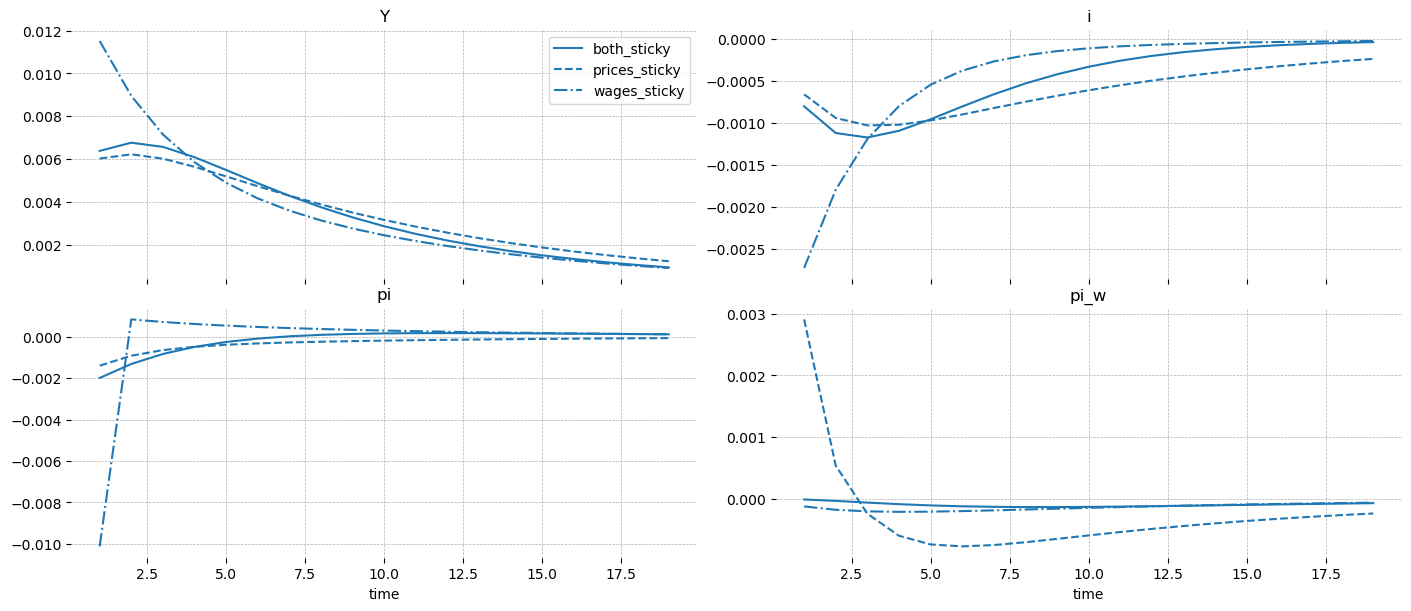

In [57]:
gp.plot_irf(
    irfs,
    vars_to_plot=["Y", "i", "pi", "pi_w"],
    shocks_to_plot=["epsilon_A"],
    n_cols=2,
    figsize=(14, 6),
);

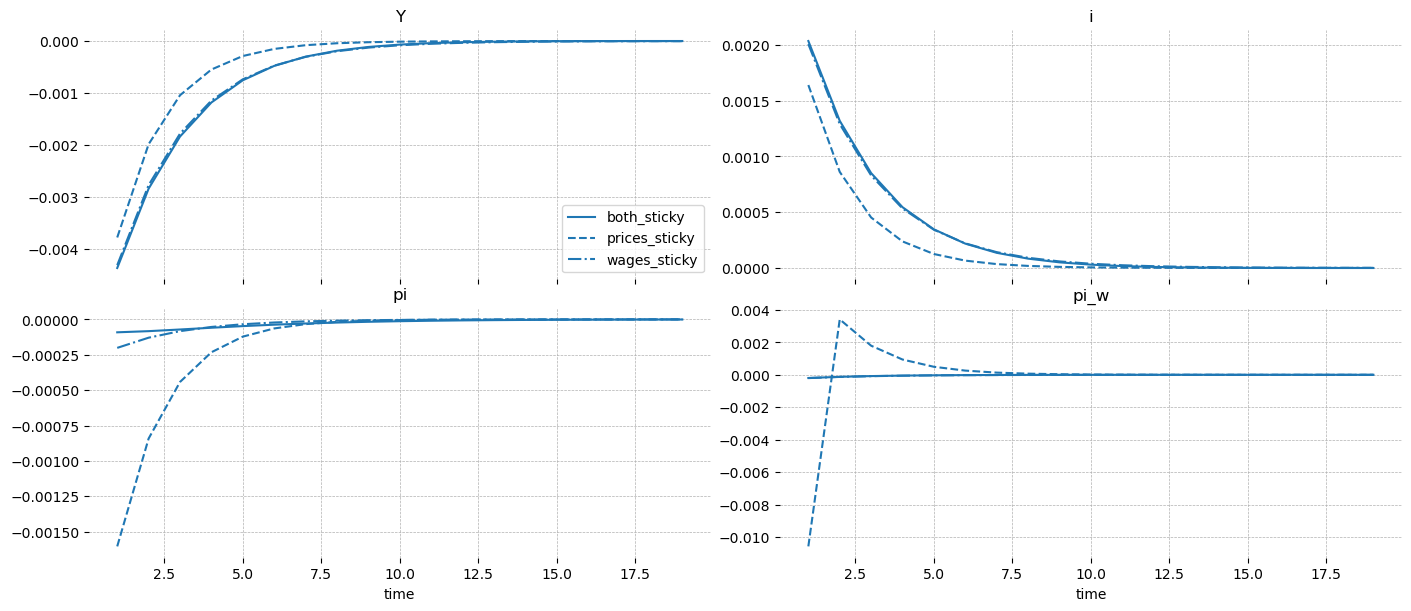

In [9]:
gp.plot_irf(
    irfs,
    vars_to_plot=["Y", "i", "pi", "pi_w"],
    shocks_to_plot=["epsilon_i"],
    n_cols=2,
    figsize=(14, 6),
);

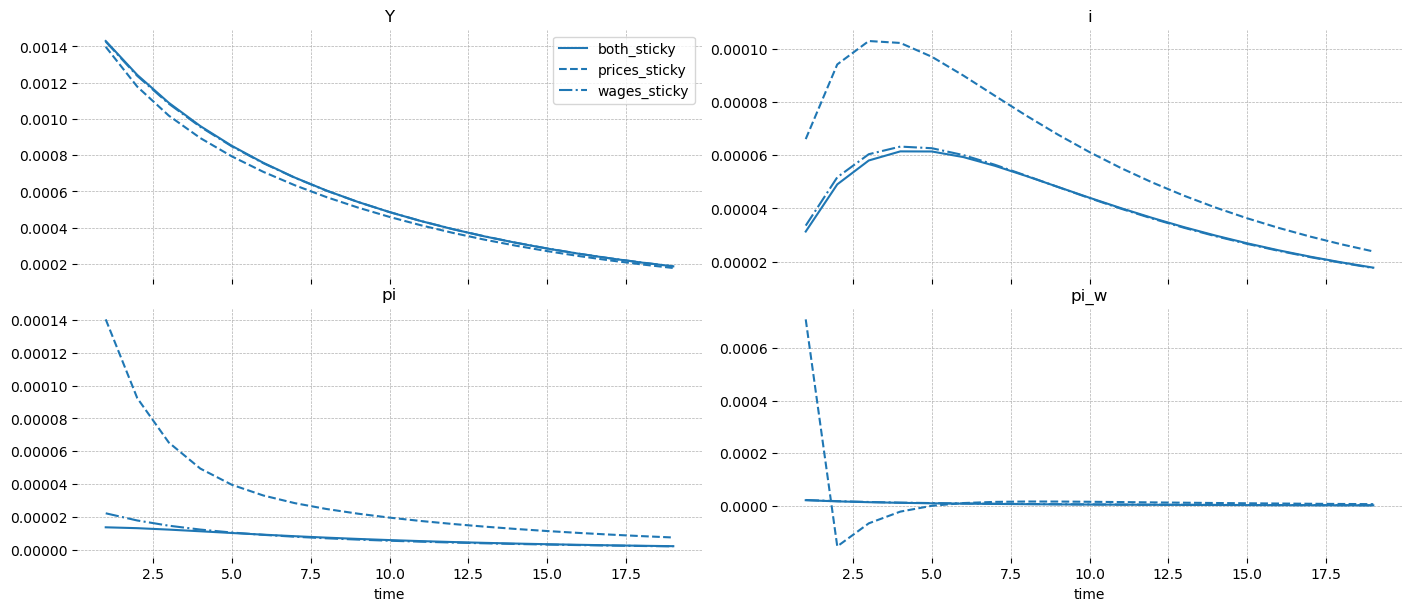

In [10]:
gp.plot_irf(
    irfs,
    vars_to_plot=["Y", "i", "pi", "pi_w"],
    shocks_to_plot=["epsilon_G"],
    n_cols=2,
    figsize=(14, 6),
);

In [46]:
ss_mod = ge.statespace_from_gcn(gcn_file, not_loglin_variables=["i", "pi", "pi_w"])

Model Building Complete.
Found:
	19 equations
	19 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t, nu_p_t
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	15 parameters
		 13 / 15 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.

Statespace model construction complete, but call the .configure method to finalize.


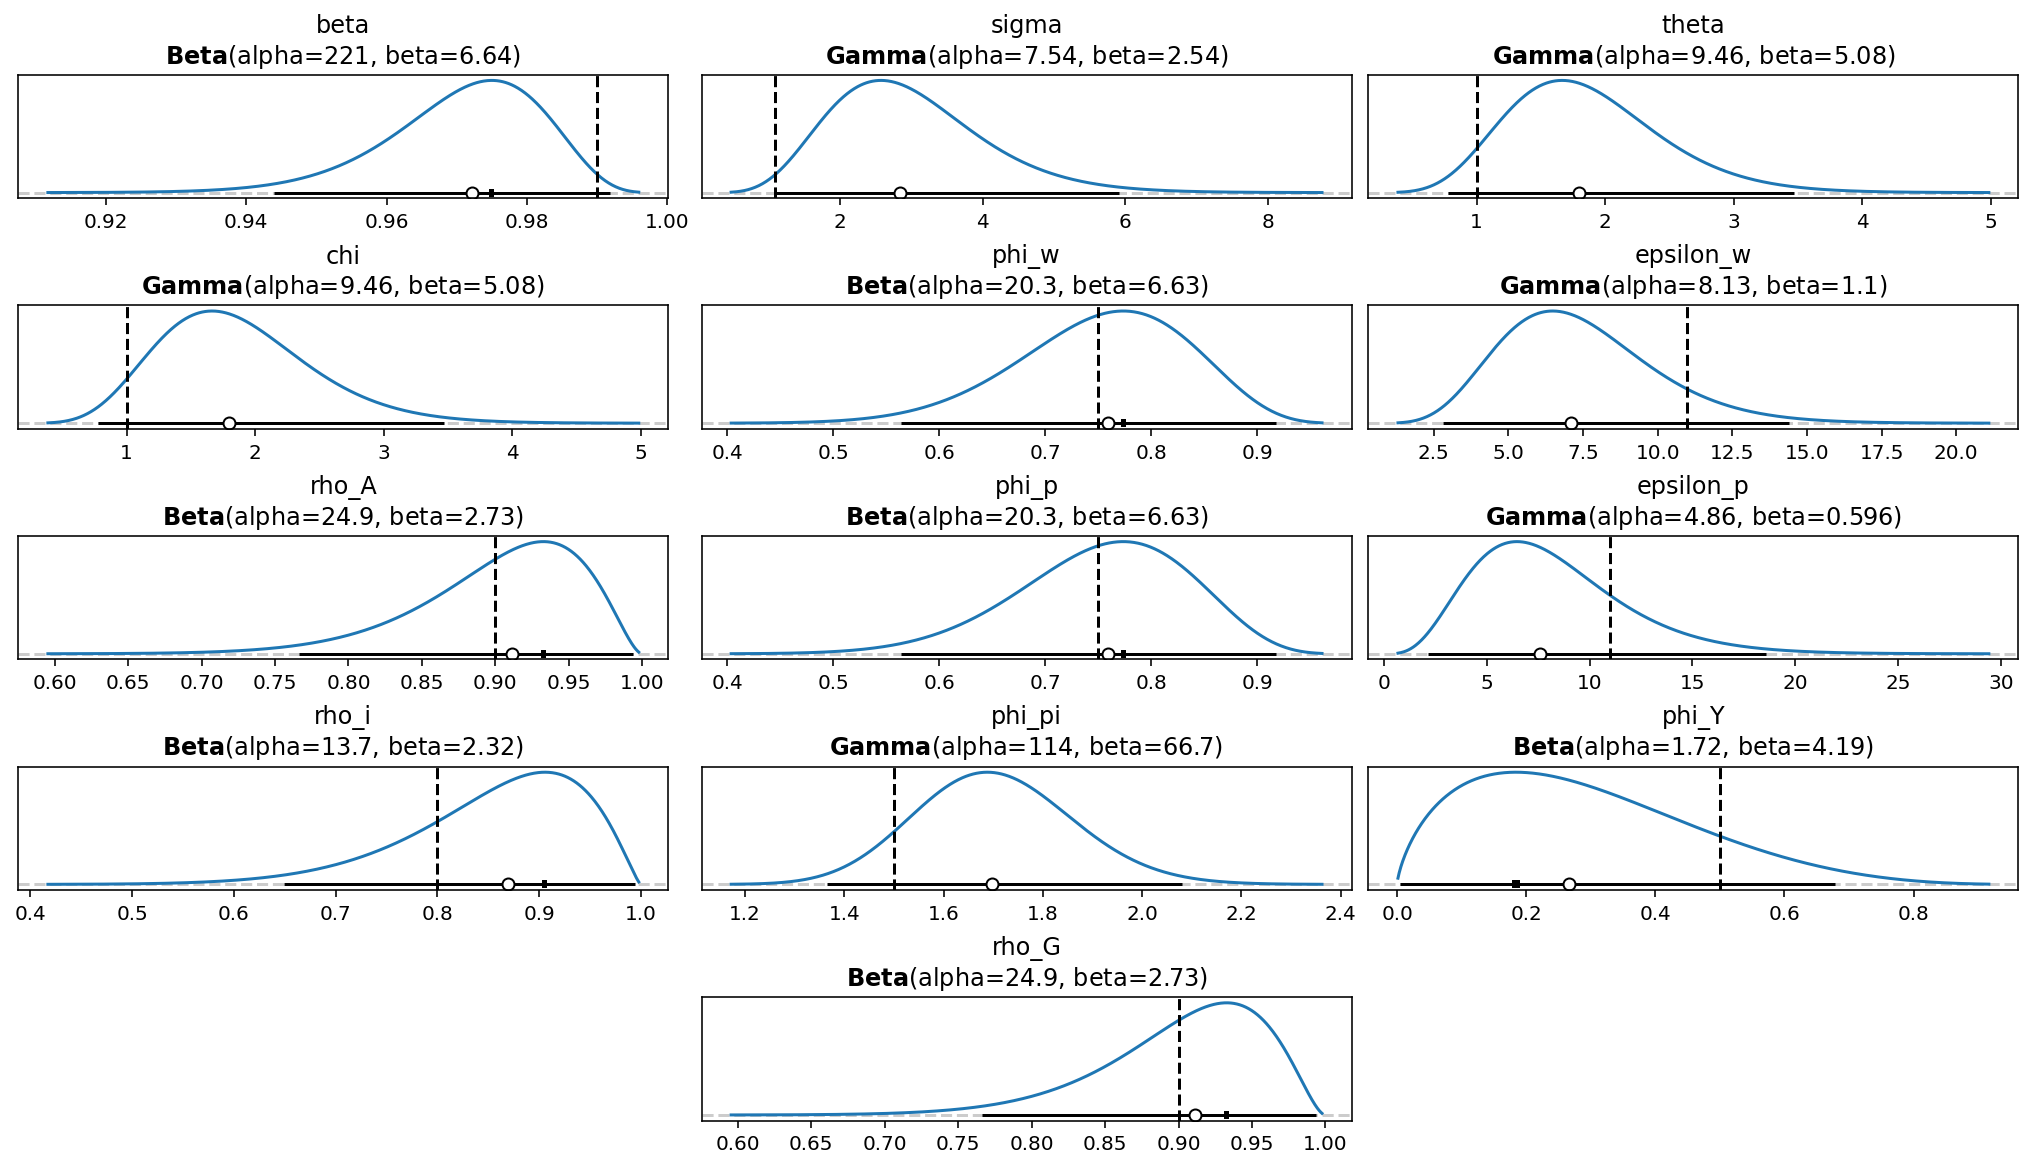

In [47]:
gp.plot_priors(ss_mod, n_cols=3);

In [48]:
ss_mod.configure(
    observed_states=["Y", "C", "N", "G", "pi", "i", "w"],
    measurement_error=["Y", "C", "N", "G", "w"],
    constant_params=["pi_bar", "psi"],
    full_shock_covaraince=True,
    solver="scan_cycle_reduction",
    mode="JAX",
    max_iter=20,
    use_adjoint_gradients=True,
)

The following parameters should be assigned priors inside a PyMC model block: 
	beta -- shape: (), constraints: None, dims: None
	chi -- shape: (), constraints: None, dims: None
	epsilon_p -- shape: (), constraints: None, dims: None
	epsilon_w -- shape: (), constraints: None, dims: None
	phi_Y -- shape: (), constraints: None, dims: None
	phi_p -- shape: (), constraints: None, dims: None
	phi_pi -- shape: (), constraints: None, dims: None
	phi_w -- shape: (), constraints: None, dims: None
	rho_A -- shape: (), constraints: None, dims: None
	rho_G -- shape: (), constraints: None, dims: None
	rho_i -- shape: (), constraints: None, dims: None
	sigma -- shape: (), constraints: Positive, dims: None
	theta -- shape: (), constraints: None, dims: None
	state_cov -- shape: (3, 3), constraints: Positive Semi-Definite, dims: ('shock', 'shock_aux')
	error_sigma_Y -- shape: (), constraints: None, dims: None
	error_sigma_C -- shape: (), constraints: None, dims: None
	error_sigma_N -- shape: (), constr

In [49]:
import pymc as pm
import preliz as pz

all_priors = ss_mod.param_priors | ss_mod.shock_priors
sd_dist = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False).to_pymc()

with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    for var_name in ss_mod.error_states:
        x = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False)
        all_priors[f"error_sigma_{var_name}"] = x
        x.to_pymc(name=f"error_sigma_{var_name}")

    chol, *_ = pm.LKJCholeskyCov("state_chol", n=3, eta=6, sd_dist=sd_dist)
    cov = pm.Deterministic("state_cov", chol @ chol.T, dims=["shock", "shock_aux"])

In [52]:
date_range = pd.date_range(start="1980-01-01", end="2024-11-01", freq="QS-OCT")
true_params, data = ge.data_from_prior(
    ss_mod, pm_mod, index=date_range, n_samples=10, pct_missing=0.01
)

Sampling: [beta, chi, epsilon_p, epsilon_w, error_sigma_C, error_sigma_G, error_sigma_N, error_sigma_Y, error_sigma_w, obs, phi_Y, phi_p, phi_pi, phi_w, rho_A, rho_G, rho_i, sigma, state_chol, theta]
Sampling: [prior_combined]


Output()

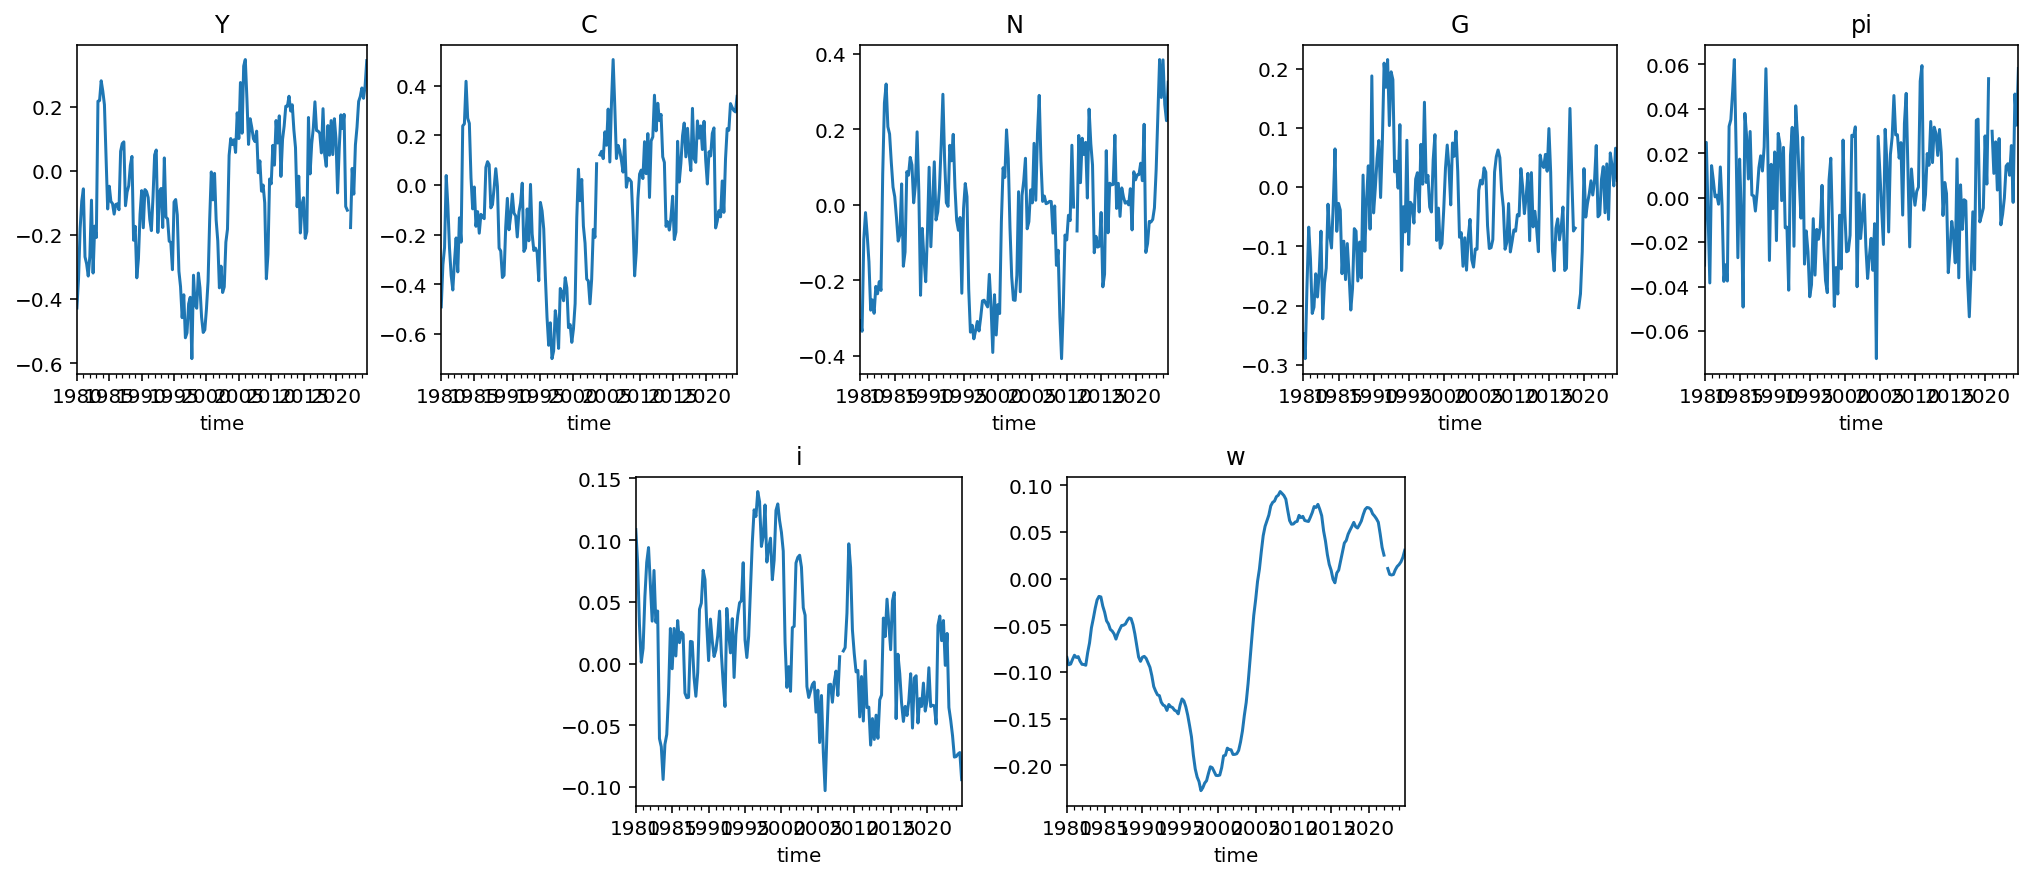

In [53]:
fig = plt.figure(figsize=(14, 6), dpi=144, layout="constrained")
gs, locs = gp.prepare_gridspec_figure(
    n_plots=len(ss_mod.observed_states), n_cols=5, figure=fig
)
for loc, col in zip(locs, data):
    axis = fig.add_subplot(gs[loc])
    data[col].plot(ax=axis, legend=False, title=col)

In [54]:
ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(pm_mod),
    backend="jax",
    gradient_backend="jax",
    default_initialization_strategy="prior",
    jitter_rvs=set(),
    #                                  initial_points=None)
    initial_points={k: v for k, v in ss_mod.param_dict.items() if k in pm_mod},
)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [55]:
idata = ntp.sample(
    ntp_mod.with_transform_adapt(
        verbose=True,
        learning_rate=1e-3,
        num_layers=50,
        #                                                 nn_width=128,
        batch_size=512,
        #                                                 initial_skip=250,
        #                                                 num_diag_windows=11,
        zero_init=False,
        dct_layer=False,
        extend_dct=False,
    ),
    tune=1500,
    draws=1000,
    chains=6,
    target_accept=0.95,
    transform_adapt=True,
)

seedseed 6236365609499897543
seed 9330884112239653389
seed 11123252588695641909
seed 14390813024204293556
 8490581738876292430
seed 17983041022138205279
Chain 5: Total available points: 11
seed 7013435885814184635
loss from diag: 5.204940990529867
Chain 0: Total available points: 11
seed 12499463318248726582
loss from diag: 1.7602529207374231
Chain 3: Total available points: 11
seed 10185870604901485778
loss from diag: 5.641420726364897
Chain 2: Total available points: 11
seed 14868358916353645504
loss from diag: 4.560661164374089
Chain 1: Total available points: 11
seed 4467757911240679573
loss from diag: 3.5169991622730157
Chain 5: Total available points: 21
seed 9200731084162542787
loss from diag: -1.2512225114212363
Chain 4: Total available points: 11
seed 10899780515853293242
loss from diag: 4.308909647962553
Chain 0: Total available points: 21
seed 7121551732362309249
loss from diag: 1.2835974922989581
Chain 5: Total available points: 31
seed 16342831432524870482
loss from diag: 

Chain 5: Total available points: 401
Extending flow...
0.4851236058784122 [0.29446939 0.38056213 0.47429451 0.3221623  0.3480939  0.23890321
 0.2918307  0.1132777  0.06761535 0.48512361 0.17585446 0.25813073
 0.06181669 0.03193839 0.04703759 0.03055172 0.0368715  0.0366289
 0.20360768 0.07289314 0.13606918 0.17104492 0.15227352 0.07181561]
dct: False
Chain 0: New loss 0.3391353744352506, old loss 2.0141812908908276
Chain 4: Total available points: 201
Chain 1: Total available points: 351
Chain 4: New loss 0.7555725389553599, old loss 4.580034303587662
Chain 2: Total available points: 301
Chain 1: New loss 1.57478131523465, old loss 1.9559550191610846
Chain 3: Total available points: 251
Chain 2: New loss 0.7037712190724079, old loss 1.2677570988887796
Chain 0: Total available points: 351
Chain 3: New loss 0.8852653159944595, old loss 2.9162579322039437
Chain 5: New loss -0.4038603881296177, old loss 1.906343872631508
Chain 0: New loss 0.8109066202261911, old loss 1.1181971899011818
Cha

Chain 1: Total available points: 751
Chain 2: New loss 0.4083692189155114, old loss 0.6987607637154858
Chain 1: New loss 0.14012696199920582, old loss 0.2447780267677616
Chain 5: Total available points: 801
Extending flow...
0.07548516625056305 [0.03745181 0.07548517 0.073361   0.05646334 0.04797672 0.02728793
 0.04686921 0.02274045 0.00201394 0.04762906 0.03232453 0.05540204
 0.01111644 0.00447133 0.00482564 0.01120534 0.01025853 0.00467582
 0.02380032 0.02928484 0.01149477 0.02753887 0.02341595 0.01576902]
dct: False
Chain 0: Total available points: 751
Chain 0: New loss 0.20753972548811084, old loss 0.308642377326681
Chain 4: Total available points: 551
Chain 4: New loss 0.5609988635645389, old loss 0.7817325340355449
Chain 1: Total available points: 801
Extending flow...
0.06866266653795587 [0.04170927 0.06739284 0.05341036 0.03596142 0.04779623 0.05949018
 0.04880571 0.02948894 0.00434898 0.06866267 0.02743953 0.0514874
 0.02964044 0.00905437 0.00594368 0.00877213 0.03153319 0.005

Chain 3: Total available points: 1051
Chain 2: Total available points: 1251
Chain 3: New loss -0.11364853328372167, old loss 0.0595366523771787
Chain 2: New loss 0.16487333119724326, old loss 0.4447365349918088
Chain 5: Total available points: 1251
Chain 5: New loss -0.6726531031497724, old loss -0.409308989086142
Chain 1: Total available points: 1301
Chain 4: Total available points: 951
Chain 1: New loss -0.2489558883816655, old loss 0.0015253374797759324
Chain 0: Total available points: 1251
Chain 4: New loss -0.09373569488029454, old loss 0.06285473928015758
Chain 0: New loss -0.3259746807637365, old loss -0.11573522746996066
Chain 3: Total available points: 1101
Chain 2: Total available points: 1301
Chain 3: New loss 0.1474181979783788, old loss 0.29687584793059996
Chain 2: New loss 0.14595279919080795, old loss 0.3598906637673409
Chain 5: Total available points: 1301
Chain 5: New loss -0.7739110637470228, old loss -0.5509647239940352
Chain 4: Total available points: 1001
Chain 0: 

<Axes: >

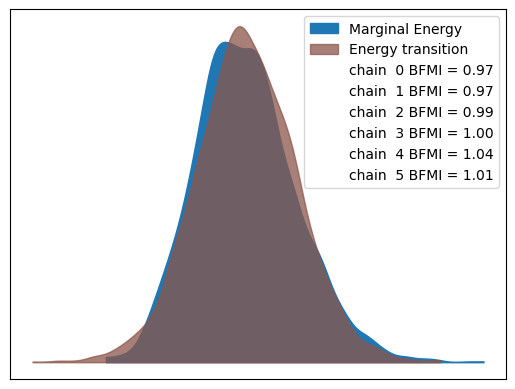

In [27]:
az.plot_energy(idata)

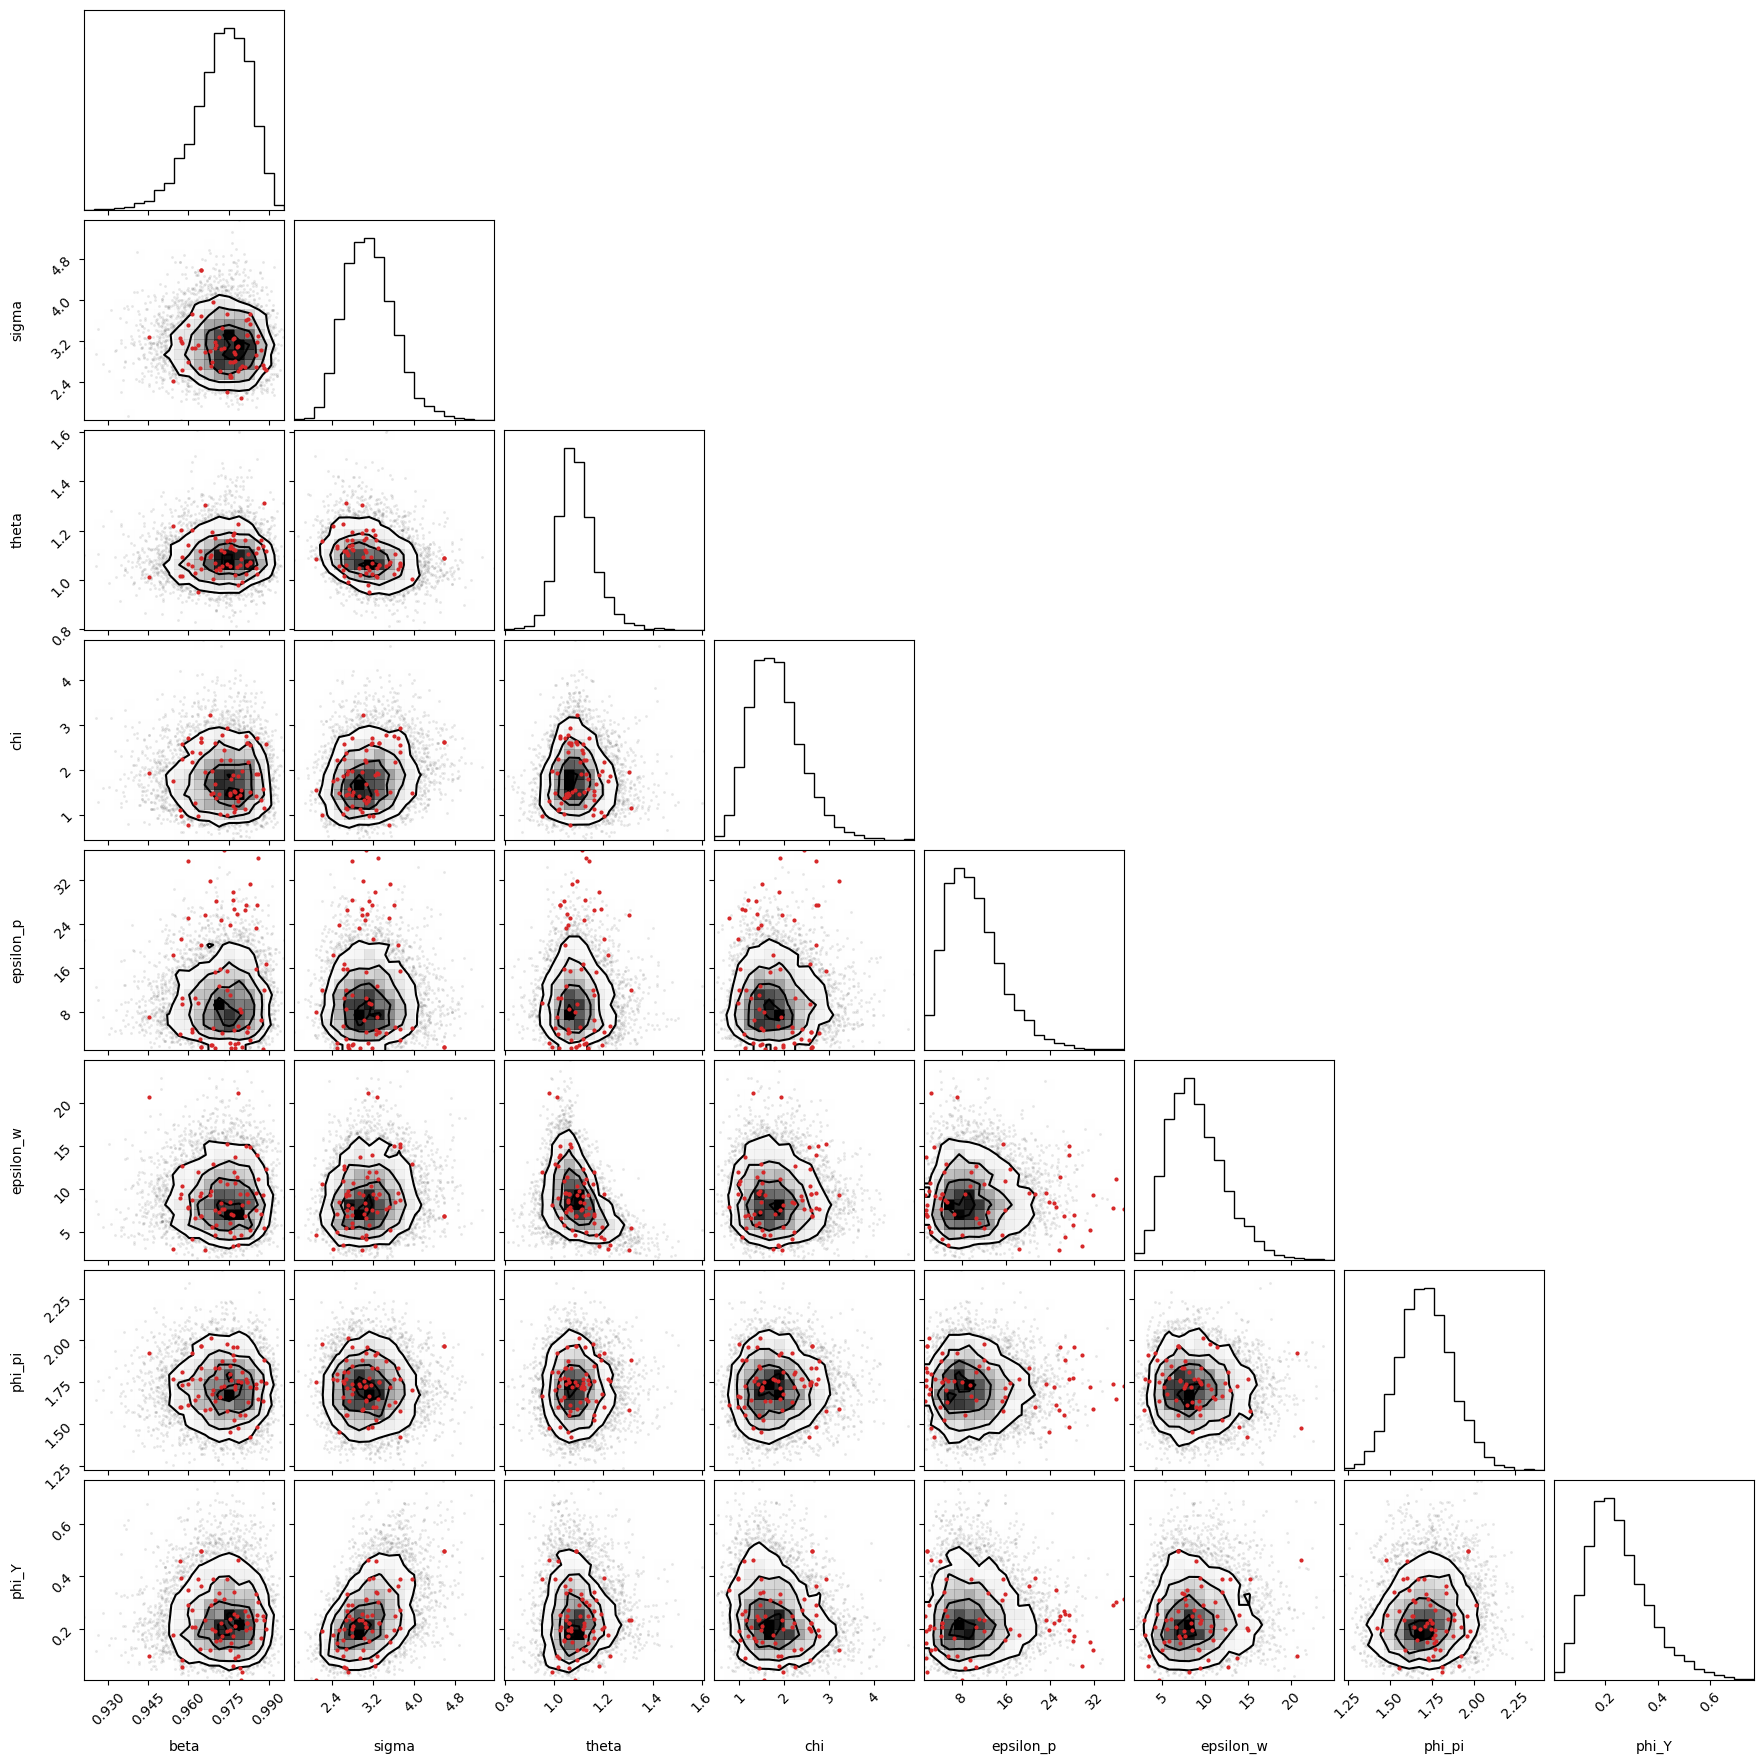

In [43]:
deep_params = [
    "beta",
    "sigma",
    "theta",
    "chi",
    "epsilon_p",
    "epsilon_w",
    "phi_pi",
    "phi_Y",
]
var_names = [rv.name for rv in pm_mod.free_RVs]
corner(
    idata,
    var_names=deep_params,
    divergences=True,
    divergences_kwargs={"markersize": 4, "color": "tab:red"},
);

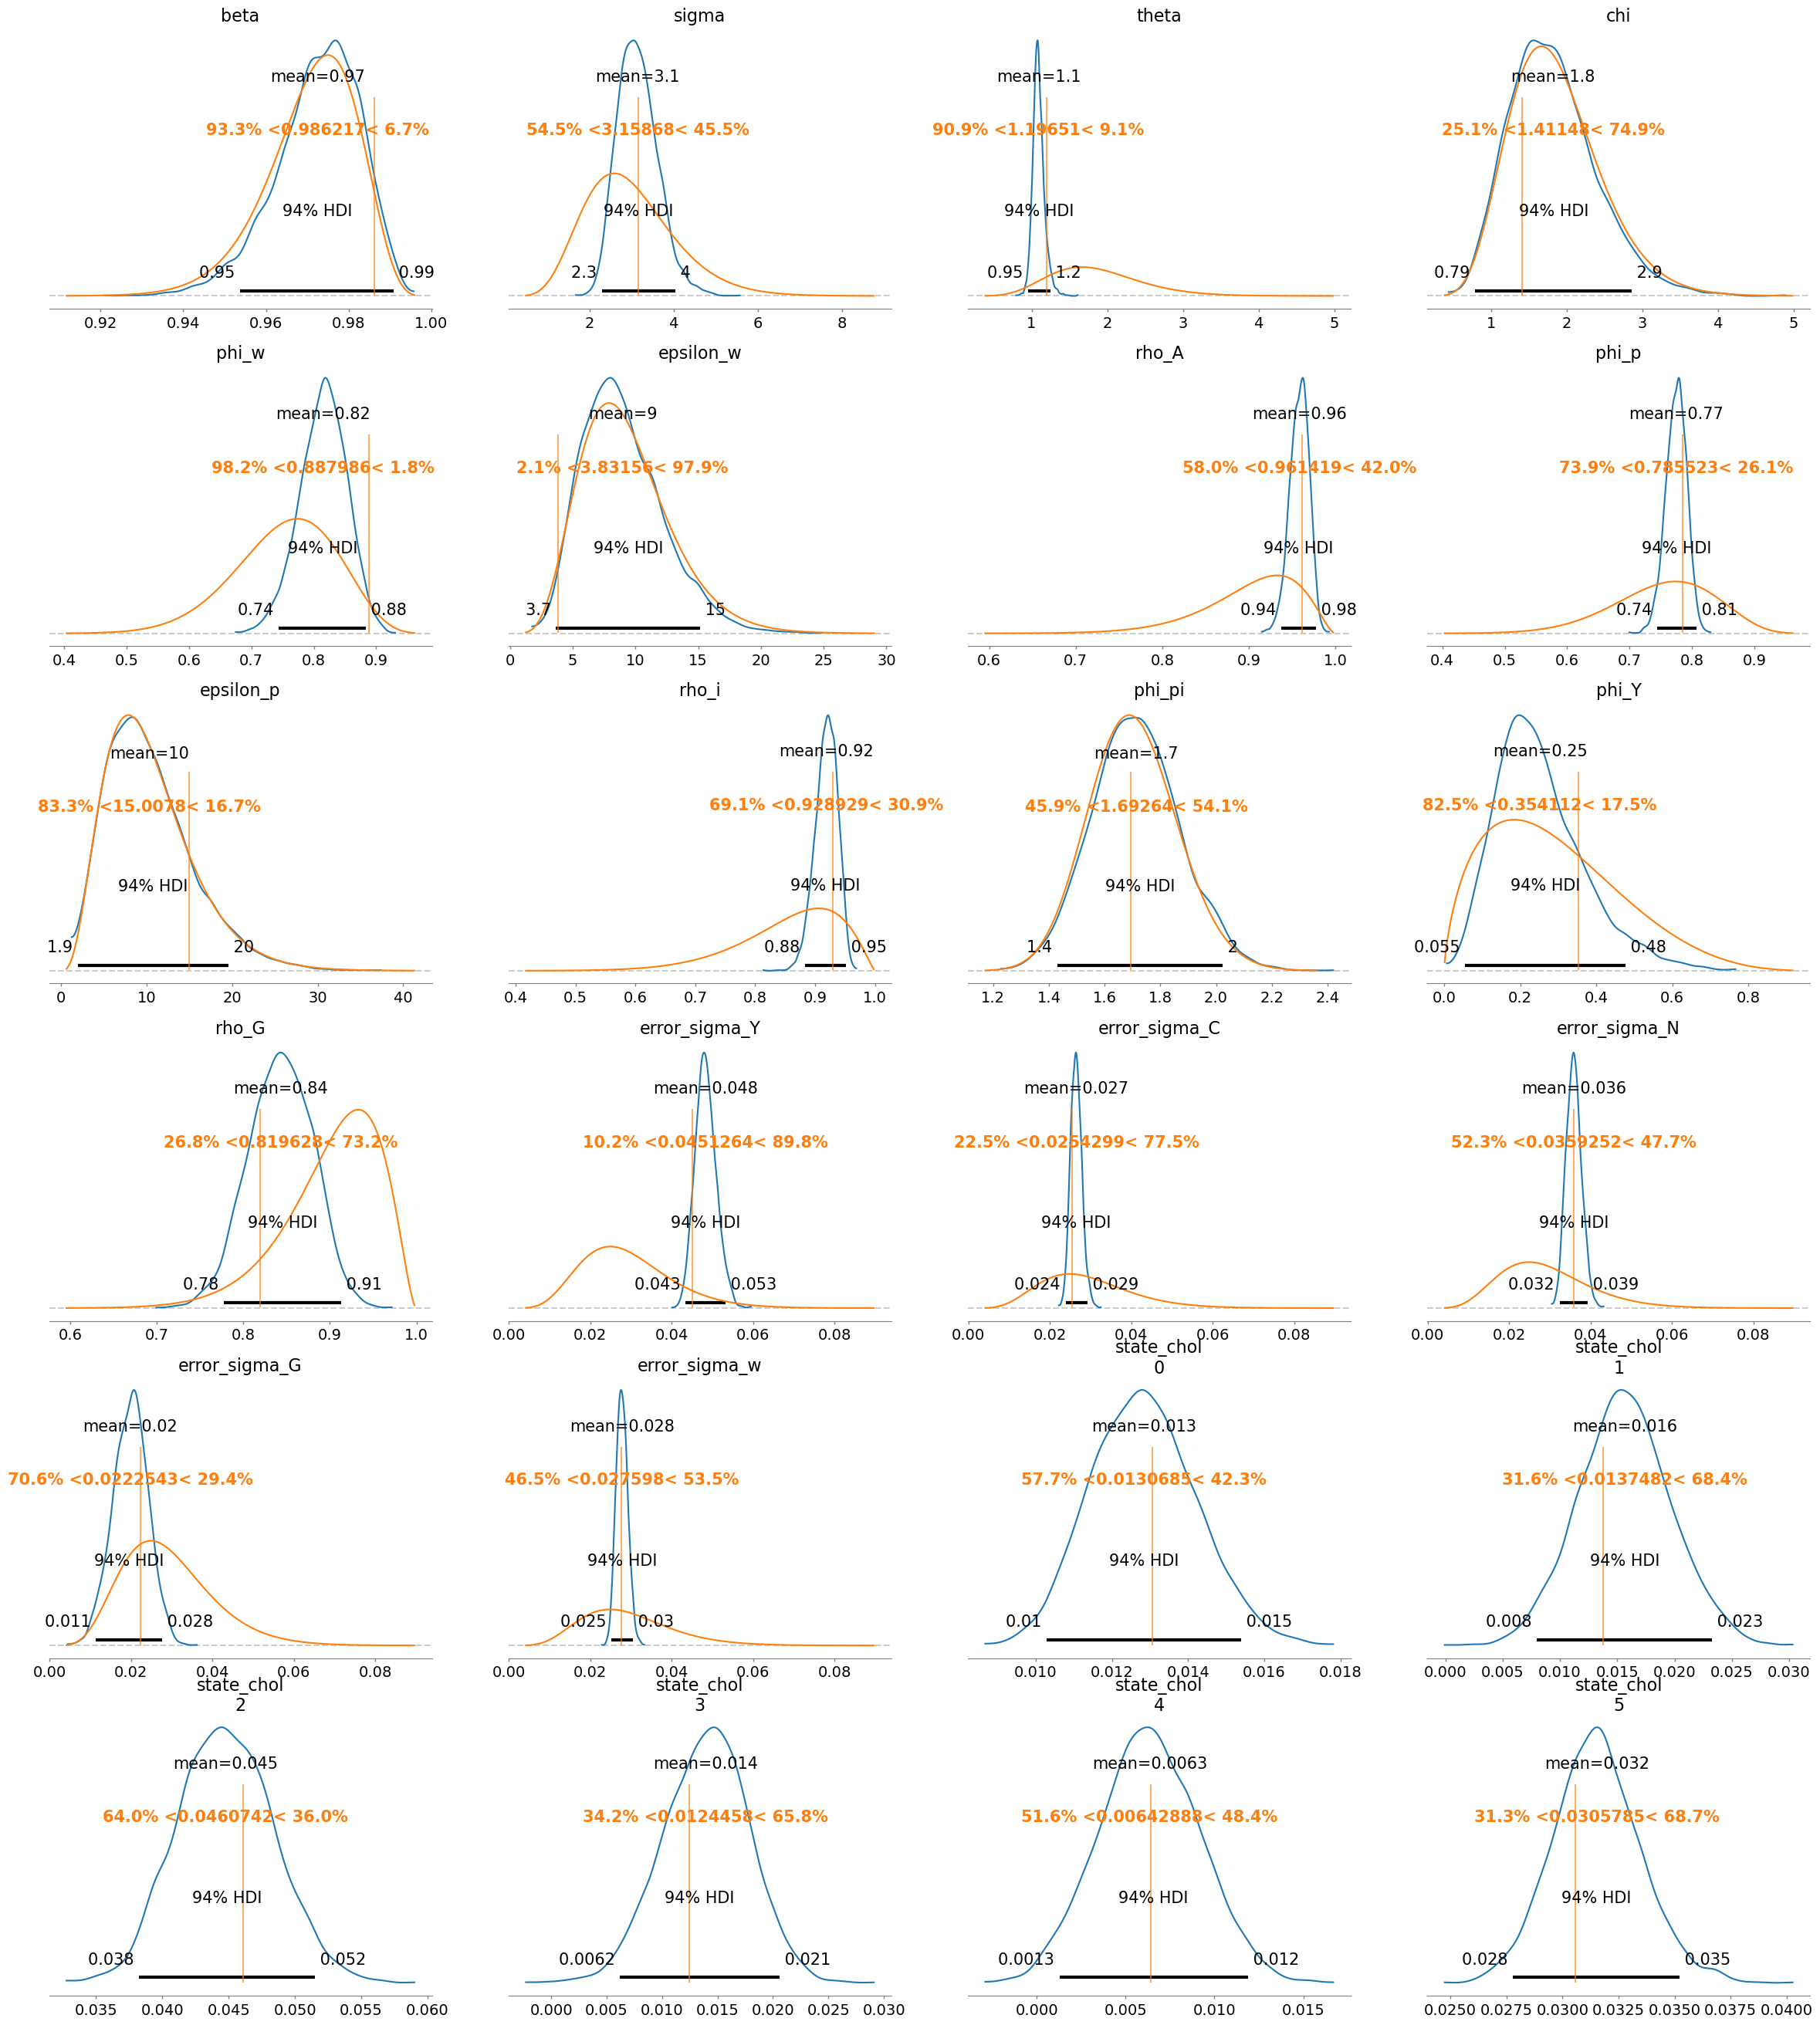

In [29]:
axes = az.plot_posterior(
    idata,
    var_names=var_names,
    ref_val=np.r_[*[true_params[name].values.ravel() for name in var_names]].tolist(),
)
for axis in axes.ravel():
    var_name, *coords = axis.get_title().split("\n")

    if var_name in all_priors:
        all_priors[var_name].plot_pdf(ax=axis, legend=False, color="tab:orange")

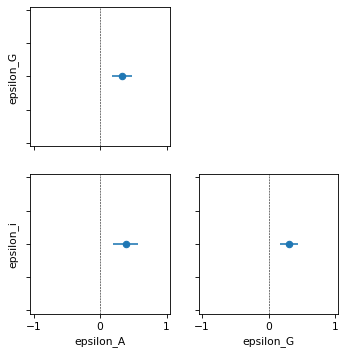

In [22]:
from itertools import product

fig, ax = plt.subplots(
    3,
    3,
    figsize=(8, 8),
    dpi=77,
    subplot_kw={"aspect": "equal"},
    sharex=True,
    sharey=True,
)
mu = idata.posterior.state_chol_corr.mean(dim=["chain", "draw"])
hdi = az.hdi(idata.posterior.state_chol_corr).state_chol_corr
ax[0, 0].set(xlim=(-1.05, 1.05), ylim=(-1.05, 1.05))

for i, j in product(range(3), range(3)):
    axis = ax[i, j]
    if i <= j:
        axis.set_visible(False)
        continue
    y_var = mod.shocks[i].base_name
    x_var = mod.shocks[j].base_name
    axis.scatter(mu.values[i, j], 0)
    axis.hlines(0, *hdi.values[i, j])
    axis.axvline(0, ls="--", c="k", lw=0.5)

    axis.set(
        ylabel=y_var if j == 0 else "", xlabel=x_var if i == 2 else "", yticklabels=[]
    )

In [23]:
cond_post = ss_mod.sample_conditional_posterior(idata)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x3C92984A0>), RNG(<Generator(PCG64) at 0x3C92983C0>), RNG(<Generator(PCG64) at 0x3C92982E0>), RNG(<Generator(PCG64) at 0x3C9298200>), RNG(<Generator(PCG64) at 0x3C9298120>), RNG(<Generator(PCG64) at 0x3D1AD8900>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

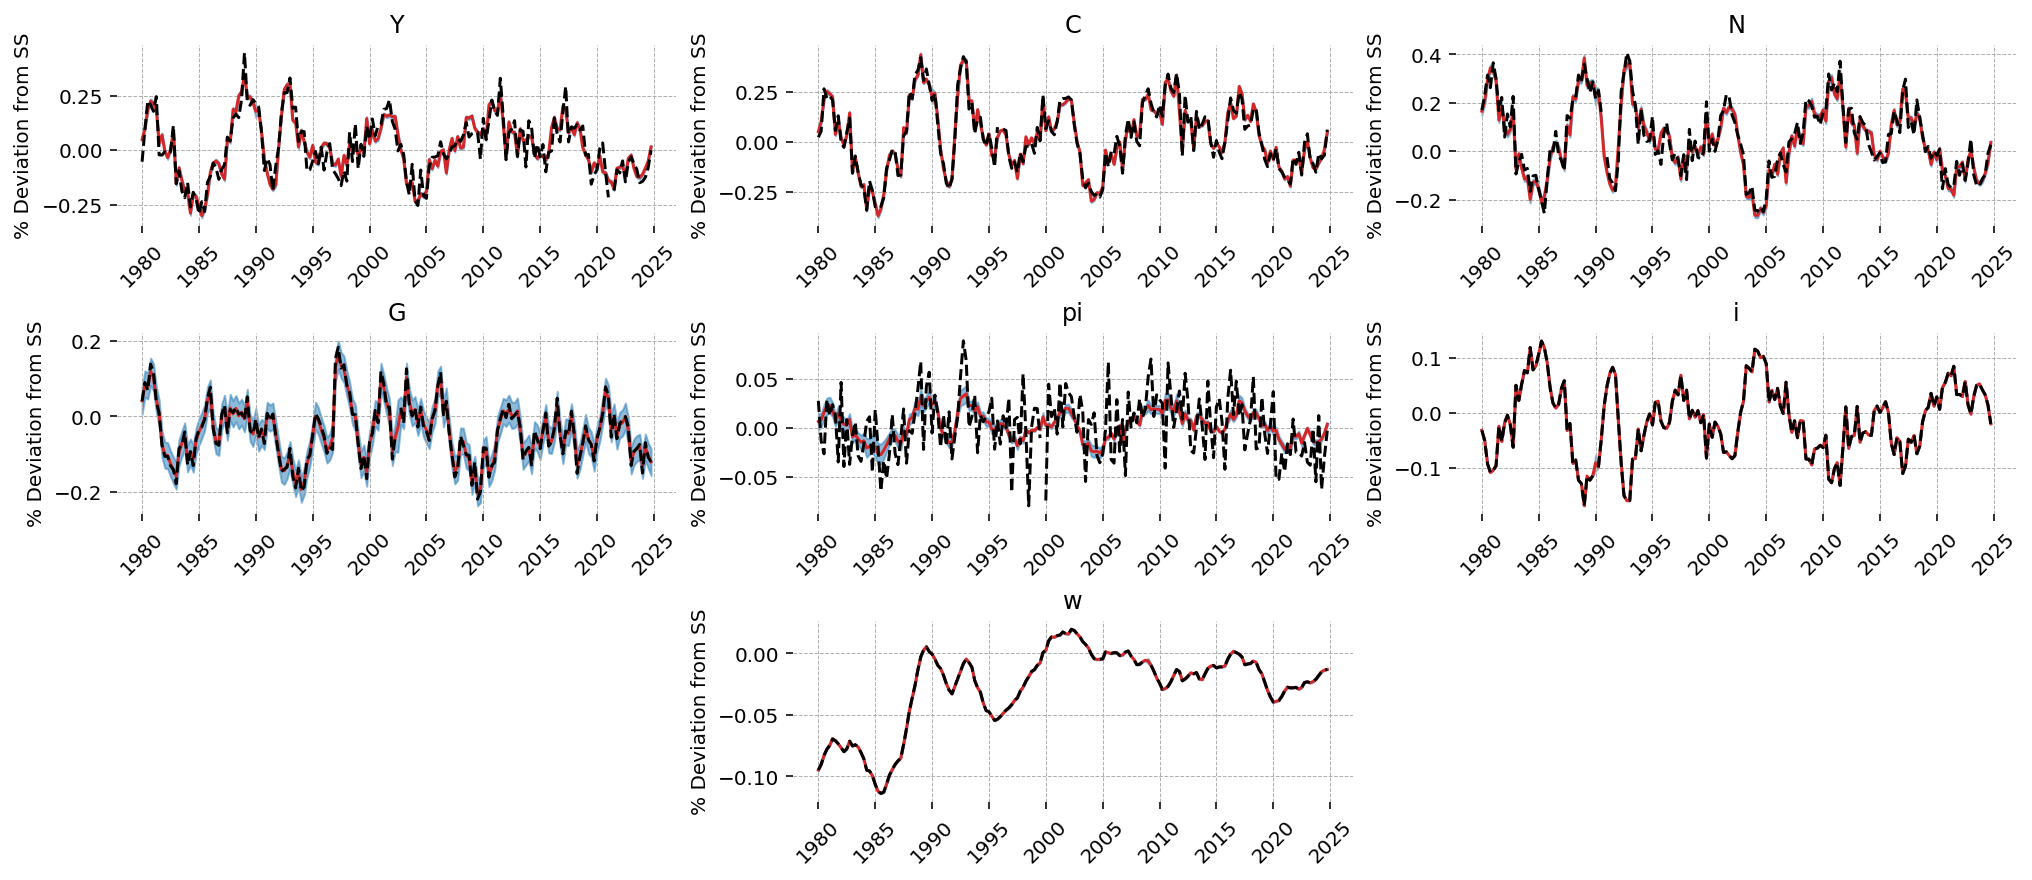

In [24]:
gp.plot_kalman_filter(
    cond_post,
    data,
    kalman_output="smoothed",
    n_cols=3,
    vars_to_plot=ss_mod.observed_states,
);

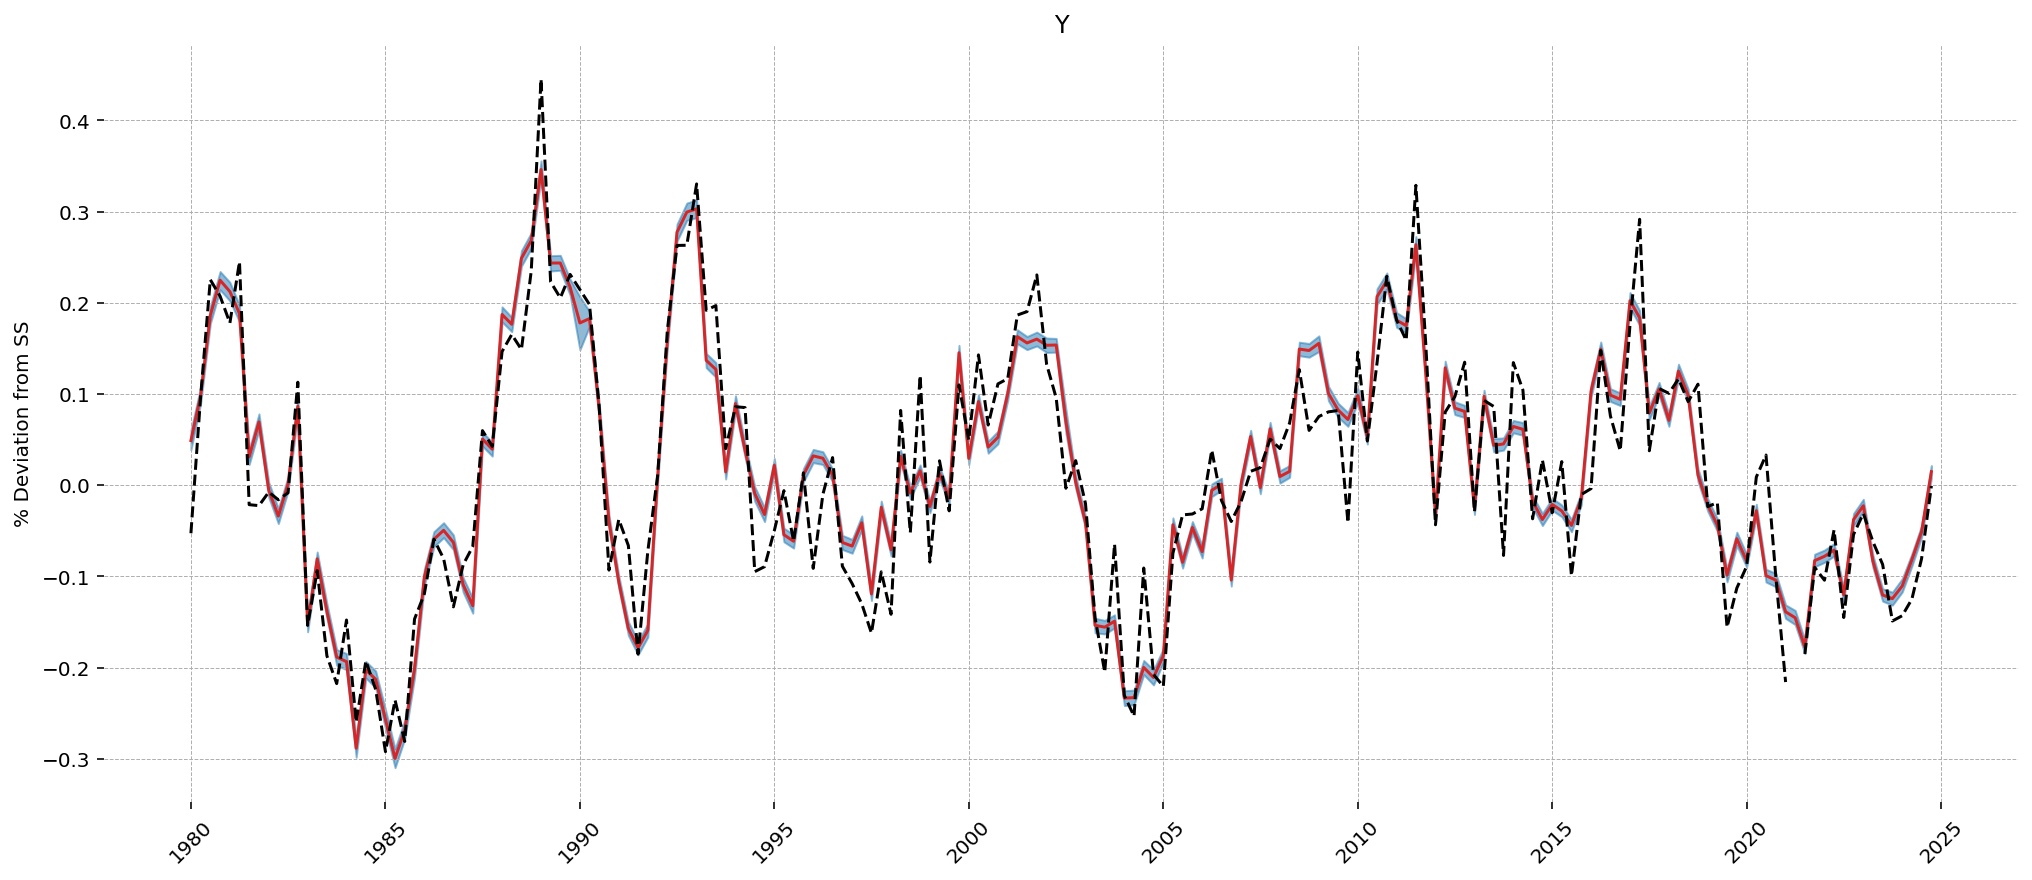

In [25]:
gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["Y"]
);

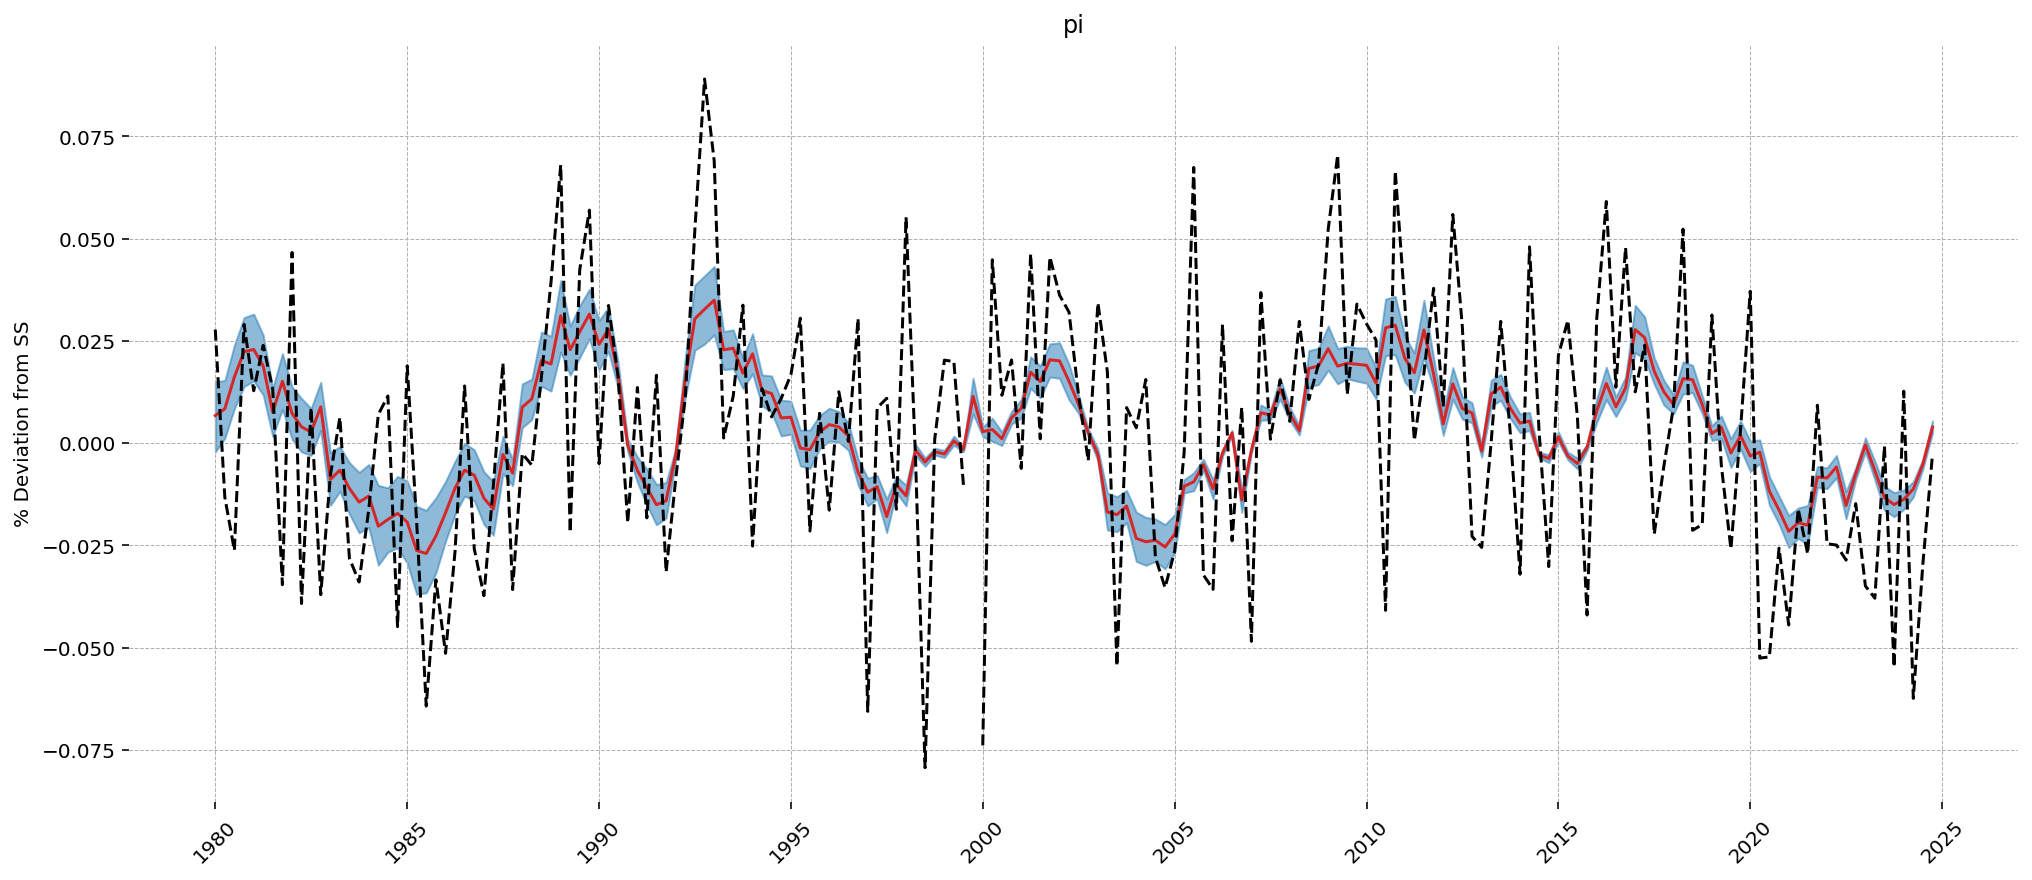

In [26]:
gp.plot_kalman_filter(
    cond_post, data, kalman_output="smoothed", n_cols=1, vars_to_plot=["pi"]
);